# LIBRARIES

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
import librosa.display

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, Shift

import random
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# RAVDESS SPEECH DATASETS

In [2]:
ravdess = "RAVDESS_SPEECH"
ravdess_directory_list = os.listdir(ravdess)
print(ravdess_directory_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [3]:
file_emotion = []
file_path = []
for actor_folder in ravdess_directory_list:
    actor_path = os.path.join(ravdess, actor_folder)

    # Make sure it’s a directory (not a hidden file, etc.)
    if os.path.isdir(actor_path):
        for file_name in os.listdir(actor_path):
            if file_name.endswith('.wav'):
                parts = file_name.split('.')[0].split('-')

                # Extract the emotion part (index 2)
                emotion = int(parts[2])
                full_path = os.path.join(actor_path, file_name)

                file_emotion.append(emotion)
                file_path.append(full_path)

In [4]:
ravdess_df = pd.DataFrame({'Emotion': file_emotion,
                           'Path': file_path})
ravdess_df

Emotion                                              Path
0           1  RAVDESS_SPEECH\Actor_01\03-01-01-01-01-01-01.wav
1           1  RAVDESS_SPEECH\Actor_01\03-01-01-01-01-02-01.wav
2           1  RAVDESS_SPEECH\Actor_01\03-01-01-01-02-01-01.wav
3           1  RAVDESS_SPEECH\Actor_01\03-01-01-01-02-02-01.wav
4           2  RAVDESS_SPEECH\Actor_01\03-01-02-01-01-01-01.wav
...       ...                                               ...
1435        8  RAVDESS_SPEECH\Actor_24\03-01-08-01-02-02-24.wav
1436        8  RAVDESS_SPEECH\Actor_24\03-01-08-02-01-01-24.wav
1437        8  RAVDESS_SPEECH\Actor_24\03-01-08-02-01-02-24.wav
1438        8  RAVDESS_SPEECH\Actor_24\03-01-08-02-02-01-24.wav
1439        8  RAVDESS_SPEECH\Actor_24\03-01-08-02-02-02-24.wav

[1440 rows x 2 columns]

In [5]:
ravdess_df.Emotion.replace({1: 'neutral',
                            2: 'neutral',
                            3: 'happy',
                            4: 'sad',
                            5: 'angry',
                            6: 'fearful',
                            7: 'disgust',
                            8: 'surprised'}, inplace=True)
ravdess_df

C:\Users\tranh\AppData\Local\Temp\ipykernel_11524\1233336508.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ravdess_df.Emotion.replace({1: 'neutral',


Emotion                                              Path
0       neutral  RAVDESS_SPEECH\Actor_01\03-01-01-01-01-01-01.wav
1       neutral  RAVDESS_SPEECH\Actor_01\03-01-01-01-01-02-01.wav
2       neutral  RAVDESS_SPEECH\Actor_01\03-01-01-01-02-01-01.wav
3       neutral  RAVDESS_SPEECH\Actor_01\03-01-01-01-02-02-01.wav
4       neutral  RAVDESS_SPEECH\Actor_01\03-01-02-01-01-01-01.wav
...         ...                                               ...
1435  surprised  RAVDESS_SPEECH\Actor_24\03-01-08-01-02-02-24.wav
1436  surprised  RAVDESS_SPEECH\Actor_24\03-01-08-02-01-01-24.wav
1437  surprised  RAVDESS_SPEECH\Actor_24\03-01-08-02-01-02-24.wav
1438  surprised  RAVDESS_SPEECH\Actor_24\03-01-08-02-02-01-24.wav
1439  surprised  RAVDESS_SPEECH\Actor_24\03-01-08-02-02-02-24.wav

[1440 rows x 2 columns]

In [6]:
ravdess_df.Emotion.value_counts()

Emotion
neutral      288
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
Name: count, dtype: int64

# SAVEE DATASETS


In [7]:
savee = "SAVEE/ALL"
savee_directory_list = os.listdir(savee)

file_emotion = []
file_path = []

for i in savee_directory_list:
    part = i.split('.')[0].split('_')
    file_emotion.append(part[1][:-2])
    file_path.append(savee + '/' + i)

print(len(file_path))

480


In [8]:
savee_df = pd.DataFrame({'Emotion': file_emotion,
                         'Path': file_path})
print(savee_df.Emotion.value_counts())

Emotion
n     120
d      60
a      60
f      60
h      60
sa     60
su     60
Name: count, dtype: int64


In [9]:
savee_df.Emotion.replace({'n': 'neutral',
                          'd': 'disgust',
                          'a': 'angry',
                          'f': 'fearful',
                          'h': 'happy',
                          'sa': 'sad',
                          'su': 'surprised'}, inplace=True)
savee_df

C:\Users\tranh\AppData\Local\Temp\ipykernel_11524\3901992850.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  savee_df.Emotion.replace({'n': 'neutral',


Emotion                   Path
0        angry   SAVEE/ALL/DC_a01.wav
1        angry   SAVEE/ALL/DC_a02.wav
2        angry   SAVEE/ALL/DC_a03.wav
3        angry   SAVEE/ALL/DC_a04.wav
4        angry   SAVEE/ALL/DC_a05.wav
..         ...                    ...
475  surprised  SAVEE/ALL/KL_su11.wav
476  surprised  SAVEE/ALL/KL_su12.wav
477  surprised  SAVEE/ALL/KL_su13.wav
478  surprised  SAVEE/ALL/KL_su14.wav
479  surprised  SAVEE/ALL/KL_su15.wav

[480 rows x 2 columns]

# TESS DATASETS

In [10]:
tess = "TESS/TESS Toronto emotional speech set data"
tess_directory_list = os.listdir(tess)

file_emotion = []
file_path = []

for i in tess_directory_list:

    file = os.listdir(tess + '/' + i)
    for f in file:

        part = f.split('.')[0].split('_')
        file_emotion.append(part[2])
        file_path.append(tess + '/' + i + '/' + f)

In [11]:
tess_df = pd.DataFrame({'Emotion': file_emotion,
                        'Path': file_path})
print(tess_df.Emotion.value_counts())

Emotion
angry      400
disgust    400
fear       400
happy      400
neutral    400
ps         400
sad        400
Name: count, dtype: int64


In [12]:
tess_df.Emotion.replace({'fear': 'fearful',
                         'ps': 'surprised'}, inplace=True)
print(tess_df)

     Emotion                                               Path
0      angry  TESS/TESS Toronto emotional speech set data/OA...
1      angry  TESS/TESS Toronto emotional speech set data/OA...
2      angry  TESS/TESS Toronto emotional speech set data/OA...
3      angry  TESS/TESS Toronto emotional speech set data/OA...
4      angry  TESS/TESS Toronto emotional speech set data/OA...
...      ...                                                ...
2795     sad  TESS/TESS Toronto emotional speech set data/YA...
2796     sad  TESS/TESS Toronto emotional speech set data/YA...
2797     sad  TESS/TESS Toronto emotional speech set data/YA...
2798     sad  TESS/TESS Toronto emotional speech set data/YA...
2799     sad  TESS/TESS Toronto emotional speech set data/YA...

[2800 rows x 2 columns]


C:\Users\tranh\AppData\Local\Temp\ipykernel_11524\3743040608.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  tess_df.Emotion.replace({'fear': 'fearful',


# EMODB

In [13]:
EmoDB = "EmoDB\wav"
EmoDB_directory_list = os.listdir(EmoDB)

file_emotion = []
file_path = []

for i in EmoDB_directory_list:

    path = os.path.join(EmoDB, i)
    emotion = i[5:6]
    file_emotion.append(emotion)
    file_path.append(path)


In [14]:
emo_df = pd.DataFrame({'Emotion': file_emotion,
                        'Path': file_path})
emo_df = emo_df[emo_df.Emotion != 'L']

emo_df.Emotion.replace({'W': 'angry',
                        'N': 'neutral',
                        'F': 'happy',
                        'A': 'fearful',
                        'T': 'sad',
                        'E': 'disgust'}, inplace=True)

print(emo_df.Emotion.value_counts())

Emotion
angry      127
neutral     79
happy       71
fearful     69
sad         62
disgust     46
Name: count, dtype: int64


C:\Users\tranh\AppData\Local\Temp\ipykernel_11524\1865887376.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  emo_df.Emotion.replace({'W': 'angry',


# Combined DATASETS


In [15]:
combined_df = pd.concat([ravdess_df, savee_df, tess_df, emo_df])
print(combined_df.Emotion.value_counts())

Emotion
neutral      887
angry        779
happy        723
fearful      721
sad          714
disgust      698
surprised    652
Name: count, dtype: int64


# Visualization


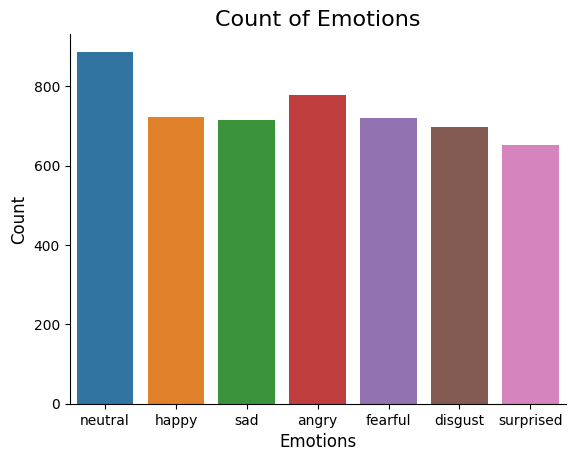

In [16]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=combined_df["Emotion"], hue=combined_df["Emotion"], legend=False)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)


Emotion: neutral


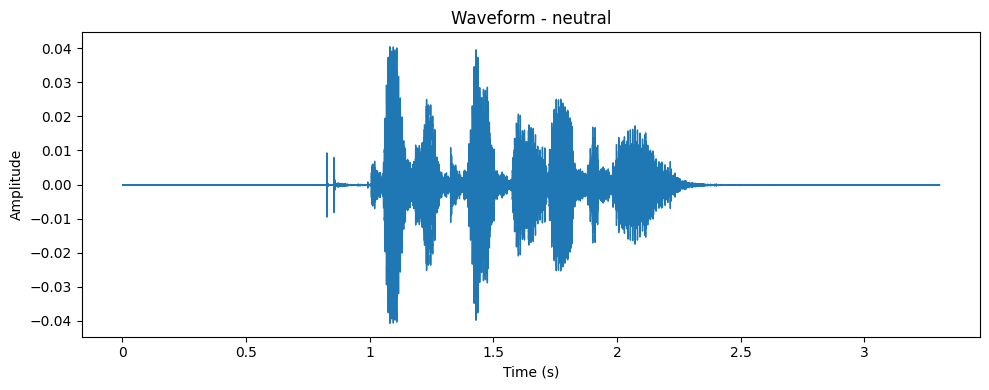


Emotion: happy


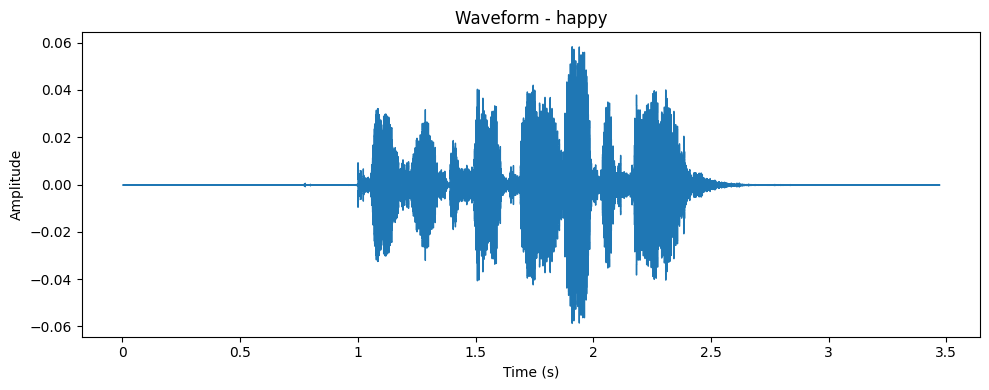


Emotion: sad


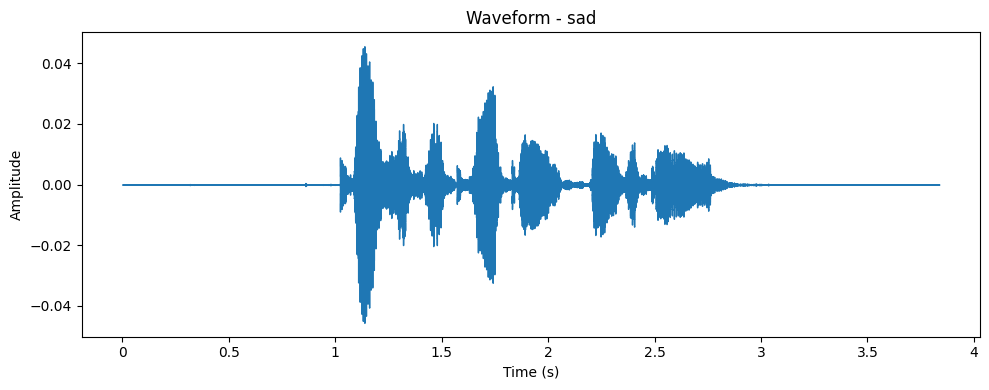


Emotion: angry


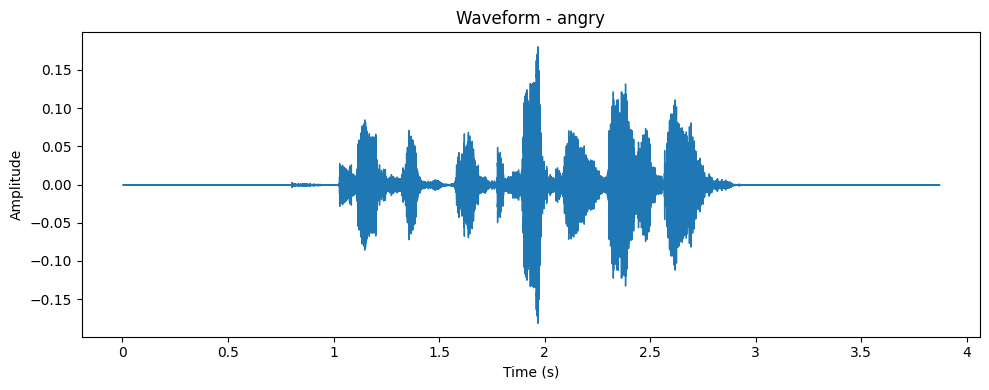


Emotion: fearful


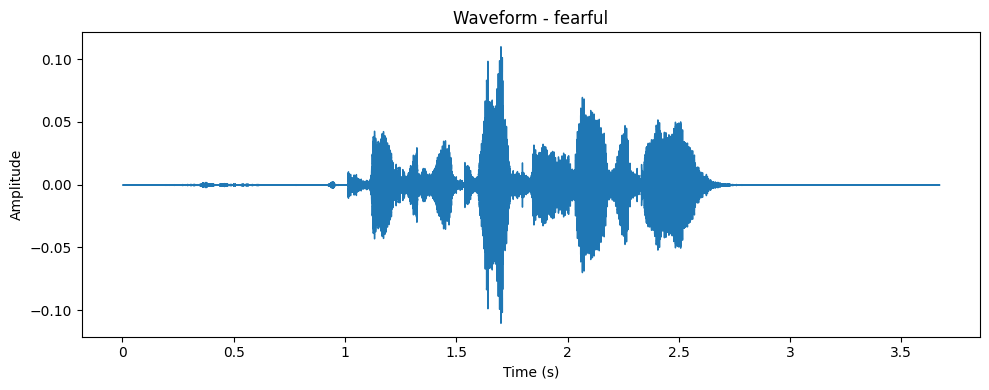


Emotion: disgust


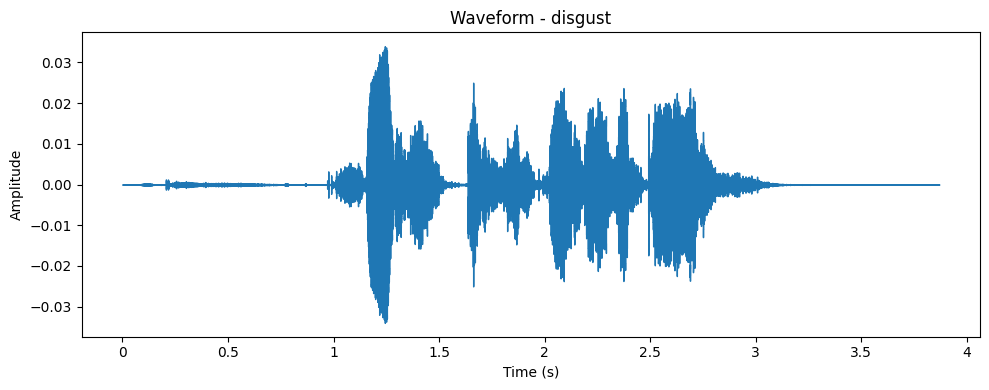


Emotion: surprised


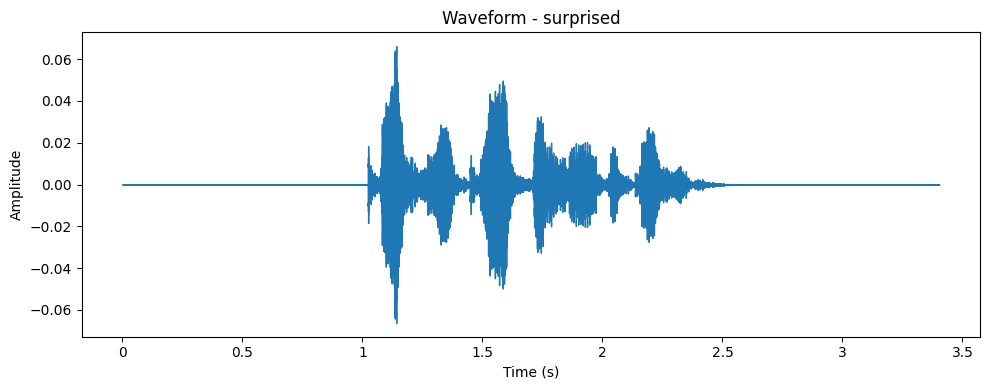

In [23]:
from IPython.display import Audio

for emotion in combined_df["Emotion"].unique():
    sample = combined_df[combined_df["Emotion"] == emotion].iloc[0]
    wav_path = sample["Path"]

    # Hiển thị tiêu đề
    print(f"\nEmotion: {emotion}")

    # Hiển thị audio player
    display(Audio(filename=wav_path))

    # Load audio và vẽ waveform
    y, sr = librosa.load(wav_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform - {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

# SET-UP 

In [17]:
SAMPLE_RATE = 22050
DURATION = 3
N_MELS = 128
TIME_STEPS = 3
FRAME_PER_STEP = 60
INPUT_SHAPE = (TIME_STEPS, N_MELS, FRAME_PER_STEP, 1)
BATCH_SIZE = 32
EPOCHS = 30

# DATA AUGMENTATION

In [18]:
augmentor = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.7),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.6),
    TimeStretch(min_rate=0.9, max_rate=1.1, p=0.5),
    Shift(min_shift=-0.2, max_shift=0.2, p=0.5),
])

# EXTRACT FEATURES

In [25]:
def audio_to_melspectrogram(audio, sr=SAMPLE_RATE):
    spectrogram = librosa.feature.melspectrogram(
        y=audio, 
        sr=sr,
        n_mels=N_MELS,
        n_fft=2048,
        hop_length=512
    )
    spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    spectrogram = (spectrogram - np.min(spectrogram)) / (np.max(spectrogram) - np.min(spectrogram) + 1e-8)
    return spectrogram

In [26]:
def load_and_process_audio(file_path, augment=False):
    audio, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Padding nếu cần
    if len(audio) < SAMPLE_RATE * DURATION:
        audio = np.pad(audio, (0, SAMPLE_RATE * DURATION - len(audio)))

    # Data augmentation (chỉ cho training)
    if augment:
        audio = augmentor(samples=audio, sample_rate=sr)

    # Chia audio thành nhiều đoạn
    chunk_len = len(audio) // TIME_STEPS
    segments = []

    for i in range(TIME_STEPS):
        chunk = audio[i * chunk_len : (i + 1) * chunk_len]

        # Xử lý từng chunk thành spectrogram chuẩn hóa
        spectrogram = audio_to_melspectrogram(chunk, sr)

        # Resize chiều width (frame) nếu cần
        if spectrogram.shape[1] < FRAME_PER_STEP:
            spectrogram = np.pad(spectrogram, ((0, 0), (0, FRAME_PER_STEP - spectrogram.shape[1])))
        else:
            spectrogram = spectrogram[:, :FRAME_PER_STEP]

        spectrogram = spectrogram[..., np.newaxis]  # Add channel
        segments.append(spectrogram)

    return np.stack(segments, axis=0)  # (time_steps, n_mels, frames, 1)


# CREATE DATASET

In [27]:
def create_dataset(file_paths, labels, batch_size=32, augment=False, shuffle=False):
    # Create label mapping
    classes = sorted(set(labels))
    label_to_index = {label: idx for idx, label in enumerate(classes)}
    
    # Convert labels to indices first
    label_indices = np.array([label_to_index[label] for label in labels])
    
    def process_path(file_path, label_idx):
        # Load spectrogram with py_function
        spectrogram = tf.py_function(
            lambda x: load_and_process_audio(x.numpy().decode('utf-8'), augment=augment),
            [file_path],
            tf.float32
        )

        # Set shape: (depth, height, width, channel)
        spectrogram.set_shape((TIME_STEPS, N_MELS, FRAME_PER_STEP, 1))
        
        # One-hot encode label
        one_hot = tf.one_hot(label_idx, depth=len(classes))
        
        return spectrogram, one_hot

    # Dataset pipeline
    ds = tf.data.Dataset.from_tensor_slices((file_paths, label_indices))
    
    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths), reshuffle_each_iteration=True)
    
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds, classes


# 3D CNN MODEL

In [36]:
def build_3d_cnn(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)  

    # Block 1
    x = layers.Conv3D(64, (1, 5, 5), activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 2
    x = layers.Conv3D(128, (1, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 3
    x = layers.Conv3D(256, (1, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 4
    x = layers.Conv3D(512, (1, 3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling3D(pool_size=(1, 2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # Block 5 (Bottleneck)
    x = layers.Conv3D(512, (1, 1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Global Pooling
    x = layers.GlobalAveragePooling3D()(x)

    # FC Block
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# FOCAL LOSS CUSTOMIZE

In [19]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=None, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, name='focal_loss'):
        super(FocalLoss, self).__init__(reduction=reduction, name=name)
        self.gamma = gamma
        self.alpha = alpha  # Now can be list or tensor

    def call(self, y_true, y_pred):
        epsilon = 1e-7
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = tf.pow(1 - y_pred, self.gamma)

        if self.alpha is not None:
            # assume alpha is a list/array of class weights
            alpha = tf.constant(self.alpha, dtype=tf.float32)
            alpha = tf.reshape(alpha, (1, -1))  # shape (1, num_classes)
            alpha_factor = y_true * alpha  # broadcast across batch
            focal_loss = alpha_factor * weight * cross_entropy
        else:
            focal_loss = weight * cross_entropy

        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

    def get_config(self):
        config = super().get_config()
        config.update({
            "gamma": self.gamma,
            "alpha": self.alpha,
        })
        return config


# DATA PREPARING

In [28]:
train_df, tmp_df = train_test_split(combined_df, test_size=0.3, stratify=combined_df['Emotion'], random_state=42)
val_df, test_df = train_test_split(tmp_df, test_size=0.5, stratify=tmp_df['Emotion'], random_state=42)

# Tạo datasets
train_ds, classes = create_dataset(train_df['Path'], train_df['Emotion'], BATCH_SIZE, augment=True, shuffle=True)
val_ds, _ = create_dataset(val_df['Path'], val_df['Emotion'], BATCH_SIZE)
test_ds, _ = create_dataset(test_df['Path'], test_df['Emotion'], BATCH_SIZE)

In [29]:
train_df.shape, val_df.shape, test_df.shape

((3621, 2), (776, 2), (777, 2))

In [30]:
train_ds, classes

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3, 128, 60, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>,
 ['angry', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised'])

# COMPUTE CLASS WEIGHT TO ALPHA

In [35]:
from sklearn.utils.class_weight import compute_class_weight

y_train_labels = np.array([classes.index(label) for label in train_df['Emotion']])
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
alpha = class_weights / np.sum(class_weights)

In [50]:
print(y_train_labels)
print(class_weights)
print(alpha)

[1 0 1 ... 3 1 5]
[0.9491481  1.06001171 1.02432815 1.02230378 0.83298827 1.03457143
 1.1343985 ]
[0.1344831  0.15019117 0.14513523 0.1448484  0.11802462 0.14658658
 0.1607309 ]


# CALLBACKS

In [ ]:
callbacks = [
    ModelCheckpoint(
        'MardeusNet.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,
        min_lr=1e-5,
        verbose=1
    )
]

# TRAINING MODEL

In [31]:
model = build_3d_cnn(INPUT_SHAPE, len(classes))
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=FocalLoss(gamma=2.0, alpha=alpha),
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1780 - loss: 0.3150
Epoch 1: val_accuracy did not improve from 0.13789
114/114 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.1782 - loss: 0.3146 - val_accuracy: 0.1379 - val_loss: 0.5435 - learning_rate: 0.0010
Epoch 2/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2529 - loss: 0.2230
Epoch 2: val_accuracy improved from 0.13789 to 0.17139, saving model to MardeusNet.keras
114/114 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.2532 - loss: 0.2228 - val_accuracy: 0.1714 - val_loss: 0.5616 - learning_rate: 0.0010
Epoch 3/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3724 - loss: 0.1624
Epoch 3: val_accuracy did not improve from 0.17139
114/114 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.3725 - loss: 0.1624 - val_accuracy: 0.1379 - val_loss: 0.7103 - learning_rate: 0.0010
Epoch 4/50
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4488 - loss: 0.1456
Epoch 4: val_accuracy did not improve from 

# EVALUATION MODEL

In [47]:
# Load best model
model.load_weights('MardeusNet.keras')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

# Confusion Matrix
y_true = []
y_pred = []

for x, y in test_ds:
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(model.predict(x), axis=1))

c:\Users\tranh\OneDrive\Máy tính\DPL\DPL\.venv\lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 62 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 793ms/step - accuracy: 0.8661 - loss: 0.0338
Test Accuracy: 0.8649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━

In [48]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       angry       0.89      0.90      0.89       117
     disgust       0.79      0.89      0.84       105
     fearful       0.84      0.86      0.85       108
       happy       0.95      0.75      0.84       109
     neutral       0.84      0.92      0.88       133
         sad       0.86      0.78      0.81       107
   surprised       0.92      0.95      0.93        98

    accuracy                           0.86       777
   macro avg       0.87      0.86      0.86       777
weighted avg       0.87      0.86      0.86       777



<Figure size 800x600 with 0 Axes>

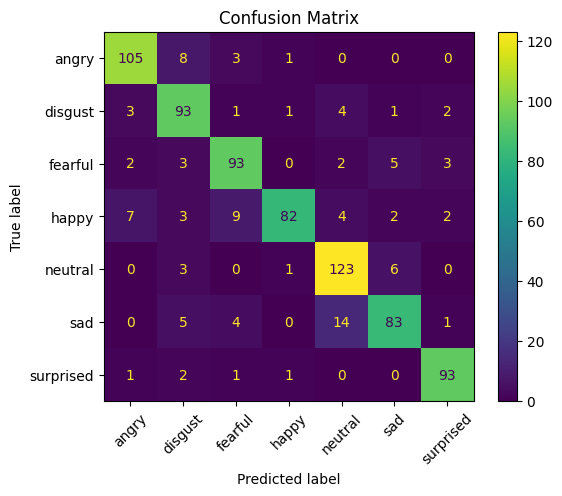

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true, y_pred)

# 4. Hiển thị
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(8, 6))
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# VISUALIZATION

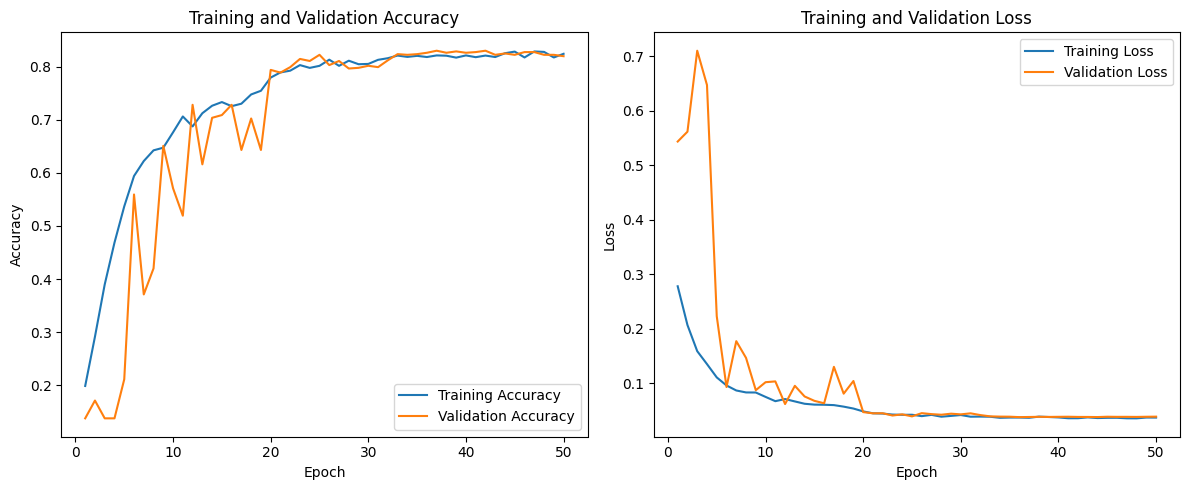

In [39]:
import matplotlib.pyplot as plt

# Extract data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


# TESTING

In [51]:
model = tf.keras.models.load_model("MardeusNet.keras", custom_objects={"FocalLoss": FocalLoss})

In [52]:
def predict_file(file_path, model, class_names):
    # Xử lý audio thành (time_steps, n_mels, frames, 1)
    spectrogram = load_and_process_audio(file_path, augment=False)

    # Thêm batch dimension → (1, time_steps, n_mels, frames, 1)
    spectrogram = np.expand_dims(spectrogram, axis=0)

    # Dự đoán
    prediction = model.predict(spectrogram, verbose=0)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = prediction[0][predicted_index]

    return predicted_class, confidence, prediction[0]

In [60]:
testing = []
folder = 'EmoDB\wav'
for audio in os.listdir(folder)[:5]:
    testing.append(os.path.join(folder, audio))

In [61]:
testing

['EmoDB\\wav\\03a01Fa.wav',
 'EmoDB\\wav\\03a01Nc.wav',
 'EmoDB\\wav\\03a01Wa.wav',
 'EmoDB\\wav\\03a02Fc.wav',
 'EmoDB\\wav\\03a02Nc.wav']

In [64]:
for path in testing:
    pred_class, conf, prob_vec = predict_file(path, model, classes)
    print(f"Predicted: {pred_class} (Confidence: {conf:.2f})")

Predicted: happy (Confidence: 0.44)
Predicted: neutral (Confidence: 0.68)
Predicted: angry (Confidence: 0.90)
Predicted: happy (Confidence: 0.36)
Predicted: neutral (Confidence: 0.43)
